In [1]:
# Orbit determination from AZ/EL observations
# Perturbation:
# N/A
# Maneuver: 
# No

# IOD
# Given from propagation_issX

# Obserbation:
# AZ/EL
# TOD / IERS_2010

# Output:
# Plot

# Remark: Implementation of the Orbdetpy methods Estimation.java

In [2]:
# Library dependencies
%matplotlib inline


from math import radians, pi, degrees
import pandas as pd
import numpy as np
import plotly.express as px


import orekit
vm = orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime
setup_orekit_curdir()

from org.orekit.orbits import KeplerianOrbit, PositionAngle
from org.orekit.propagation.analytical import KeplerianPropagator
from org.orekit.time import AbsoluteDate, TimeScalesFactory, TimeScale
from org.orekit.utils import Constants
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.attitudes import LofOffset
from org.orekit.bodies import CelestialBodyFactory, OneAxisEllipsoid
from org.orekit.forces.drag import IsotropicDrag
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.maneuvers import ImpulseManeuver
from org.orekit.frames import FramesFactory, LOFType, EOPHistory
from org.orekit.models.earth.atmosphere import HarrisPriester
from org.orekit.orbits import CircularOrbit, OrbitType, PositionAngle
from org.orekit.propagation import PropagationType, SpacecraftState
from org.orekit.propagation.events import DateDetector, EventEnablingPredicateFilter, PythonEnablingPredicate,\
     PositionAngleDetector, PythonEventDetector, AbstractDetector, EventDetector
from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder, DSSTPropagatorBuilder, \
     ClassicalRungeKuttaIntegratorBuilder, EulerIntegratorBuilder
from org.orekit.propagation.semianalytical.dsst.forces import DSSTAtmosphericDrag, DSSTNewtonianAttraction, DSSTZonal
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.utils import Constants, IERSConventions, PVCoordinatesProvider
from orekit.pyhelpers import absolutedate_to_datetime
from org.hipparchus.linear import RealMatrix
from org.hipparchus.linear import QRDecomposer, AbstractRealMatrix
from org.hipparchus.optim.nonlinear.vector.leastsquares import GaussNewtonOptimizer
from org.orekit.estimation.leastsquares import BatchLSEstimator
from org.orekit.propagation.numerical import NumericalPropagator
from org.orekit.propagation.conversion import AbstractPropagatorBuilder, PropagatorBuilder

from org.orekit.estimation.measurements import AngularAzEl
from org.orekit.estimation.measurements import ObservableSatellite
from org.orekit.estimation.measurements import GroundStation
from org.orekit.estimation.sequential import KalmanEstimatorBuilder
from org.orekit.estimation.sequential import KalmanEstimator
from org.orekit.estimation.sequential import KalmanEstimation,AbstractCovarianceMatrixProvider
from org.orekit.estimation.measurements import *
from org.orekit.estimation.iod import IodGooding, IodLaplace

from orekit.pyhelpers import absolutedate_to_datetime, datetime_to_absolutedate, JArray_double2D
from collections import namedtuple
from org.orekit.time import Month
from orekit import JArray

from org.orekit.estimation.sequential import KalmanEstimator, KalmanEstimatorBuilder, CovarianceMatrixProvider, ConstantProcessNoise
from org.orekit.orbits import Orbit
from org.hipparchus.linear import MatrixUtils

from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder
from org.orekit.propagation.conversion import NumericalPropagatorBuilder
from org.orekit.orbits import PositionAngle

from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel

from org.orekit.utils import ParameterDriver

from org.hipparchus.linear import Array2DRowRealMatrix  
from org.orekit.estimation.sequential import KalmanEstimatorBuilder, KalmanEstimation
from org.orekit.orbits import CartesianOrbit, Orbit
from org.orekit.utils import TimeStampedPVCoordinates

In [3]:
# Functions declaration

# Creation of the initial covariance matrix
def initCov(initialCov, initData, matSize):
    for i in range(0,matSize):
        initialCov.setEntry(i, i, 1.0);
        for j in range(0,i):
            initialCov.setEntry(i, j, initData[j]);
            initialCov.setEntry(j, i, initData[j]);
            #print(initData[j])
    return initialCov

def initCovLower2(initialCov, initData, matSize):
    for i in range(0,matSize):
        initialCov.setEntry(i, i, initData[i]);
        for j in range(0,i):
            initialCov.setEntry(i, j, initData[j]);
            initialCov.setEntry(j, i, initData[j]);
            #print(initData[j])
    return initialCov

def initCov2(initialCov, initData, matSize):
    for i in range(0,matSize):
        initialCov.setEntry(i, i, initData[i]);
        for j in range(0,matSize):
            initialCov.setEntry(i, j, initData[j]);
            #initialCov.setEntry(j, i, initData[j]);
            #print(initData[j])
    return initialCov

# get measurement epoch
def getAzElDate(datetime, ref):
    year = int(datetime[1:5])
    month = int(datetime[6:8])
    day = int(datetime[9:11])
    hour = int(datetime[12:14])
    minute = int(datetime[15:17])
    second = int(datetime[18:20])
    return AbsoluteDate(year, Month.getMonth(month), day, hour, minute, 0.0, ref)



In [4]:
# dataset file name
strFile = "export_visible_NoPert.csv"

In [5]:
# Initial state, date and space object information provision (Given by ADS)
a = 7000000.0  
e = 0.20
i = radians(68.0)     
omega = radians(280.0)   # perigee argument
raan = radians(0.0)  # right ascension of ascending node
lv = radians(3.0)#0.1)    # True anomaly

mass = 625.0

utc = TimeScalesFactory.getUTC()
initialDate = AbsoluteDate(2020, 1, 1, 0, 0, 00.000, utc)

In [6]:
# Simulation configuration
## Definition of the reference frame
inertialFrame =  FramesFactory.getTOD(IERSConventions.IERS_2010, False)

## Definition of the initial orbit structure: Keplerian
initialOrbit = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngle.TRUE,
                              inertialFrame, initialDate, Constants.WGS84_EARTH_MU)

# Orbit propagator parameters
prop_min_step = 60.0 # s
prop_max_step = 300.0 # s
prop_position_error = 100.0 # m

# Estimator parameters
estimator_position_scale = 1.0 # m
estimator_convergence_thres = 1e-3
estimator_max_iterations = 25
estimator_max_evaluations = 35

# Propagation type: Numerical (for EKF)
integratorBuilder = DormandPrince853IntegratorBuilder(prop_min_step, prop_max_step, prop_position_error)
kepPropagatorBuilder = NumericalPropagatorBuilder(initialOrbit,
                                                   integratorBuilder,
                                                   PositionAngle.MEAN,
                                                   estimator_position_scale)

## Force model
# Earth gravity field with degree 1 and order 1
gravityProvider = GravityFieldFactory.getNormalizedProvider(1,1)
gravityAttractionModel = HolmesFeatherstoneAttractionModel(inertialFrame, gravityProvider)
kepPropagatorBuilder.addForceModel(gravityAttractionModel)

# Add other elements to the force model if necessary:
# atmoshperic drag,
# central gravity forces,
# third body gravity forces,
# solar radiation,
# ocean and solid tides,
# general relativity ...


In [7]:
# Configuration of the parameter drivers
plst = kepPropagatorBuilder.getPropagationParametersDrivers()

dragCoefficient = ParameterDriver('Cd', 2.0, 1.0, 1.0, 3.0)
dragCoefficient.setSelected(True)
plst.add(dragCoefficient)

rpCoeffReflection = ParameterDriver('Cr', 1.5, 1.0, 1.0, 2.0)
rpCoeffReflection.setSelected(True)
plst.add(rpCoeffReflection)

estmDMCAcceleration = ParameterDriver('DMC', 0.001, 1.0, -1.0e-2, 1.0e-2)
estmDMCAcceleration.setSelected(True)
plst.add(estmDMCAcceleration)

In [8]:
# Ground station configuration
errDeg = 0.001 
azBaseWeight = 1.0
elBaseWeight = 1.0

frame = FramesFactory.getTOD(IERSConventions.IERS_2010, False)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         frame)

longitude = radians(21.038)
latitude  = radians(67.8790708)
altitude  = 527.0
station = GeodeticPoint(latitude, longitude, altitude)
stationFrame = TopocentricFrame(earth, station, "Kiruna")

In [9]:
# Initial covariance matrix generation
matSize = 9
Q = MatrixUtils.createRealDiagonalMatrix([1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 10.0, 10.0, 10.0])

initialCov = Array2DRowRealMatrix(matSize,matSize)
initData = [1e6, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 1.00, 0.25, 1e-1, 1e-1,1e-1]

initialCov = initCovLower2(initialCov, initData, matSize)

In [10]:
# Extended Kalman Filter definition
processNoise = ConstantProcessNoise(initialCov, Q)
kalman = KalmanEstimatorBuilder().addPropagationConfiguration(kepPropagatorBuilder, processNoise) # KalmanEstimatorBuilder
filter = kalman.build() # KalmanEstimator
ObsSat= ObservableSatellite(0) # From R5

In [11]:
# Data file loading
#Open and collect data from csv
file = pd.read_csv(strFile)
az = file['azimuth']
el = file['elevation']
datetime = file['pv']
idx = datetime[0].find(',')

In [12]:
# EKF variables initialization
EKF_a = []  
EKF_e = [] 
EKF_i = []     
EKF_omega = []  
EKF_raan = []  
EKF_lv = [] 
newCovMatrix = []

Elt1 = []
Elt2 = []
Elt3 = []
Elt4 = []
Elt5 = []
Elt6 = []

Kk = []

iFail = 0
FAIL_MAX = 50

In [13]:
# EKF data processing
for j in range(0,min(9999,len(az))):
        
    date = getAzElDate(datetime[j], utc)
    orekitAzEl = AngularAzEl(GroundStation(stationFrame),
                    date,
					JArray('double')([radians(az[j]),radians(el[j])]),
                    JArray('double')([radians(errDeg),radians(errDeg)]),
                    JArray('double')([azBaseWeight,elBaseWeight]),
                    ObsSat)
    try:
        filter.estimationStep(orekitAzEl)
        
        newEstimatedState = filter.getPhysicalEstimatedState()

        EKF_a.append(newEstimatedState.getEntry(0))
        EKF_e.append(newEstimatedState.getEntry(1))
        EKF_i.append(newEstimatedState.getEntry(2))
        EKF_omega.append(newEstimatedState.getEntry(3))
        EKF_raan.append(newEstimatedState.getEntry(4))
        EKF_lv.append(newEstimatedState.getEntry(5))
        
        newCovMatrix.append(filter.getPhysicalEstimatedCovarianceMatrix())
           
        Elt1.append(newCovMatrix[-1].getEntry(1, 1))
        Elt2.append(newCovMatrix[-1].getEntry(2, 2))
        Elt3.append(newCovMatrix[-1].getEntry(3, 3))
        Elt4.append(newCovMatrix[-1].getEntry(4, 4))
        Elt5.append(newCovMatrix[-1].getEntry(5, 5))
        Elt6.append(newCovMatrix[-1].getEntry(6, 6))

    except:
        print('Problem iteration: ', j)
        iFail += 1
        # Computation fail limiter
        if iFail >= FAIL_MAX:
            break        

a = filter.getCurrentDate()
print(a,newEstimatedState)

2020-01-02T23:48:00.000 {7,000,763.3659962965; 0.2002572118; 1.1867590611; 4.8900165035; -0.0000766637; 185.5001972233; 1.9931688203; 1.4931688203; -0.0058311797}


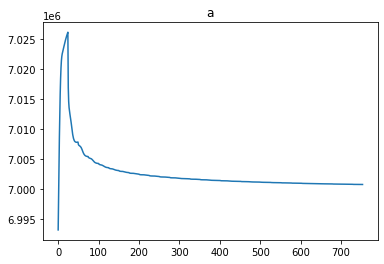

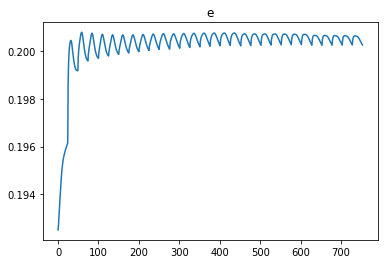

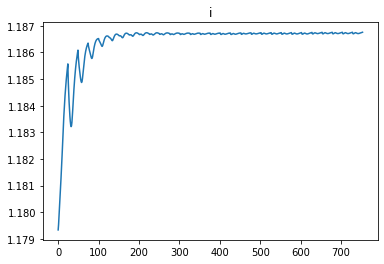

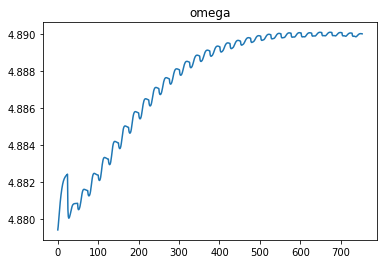

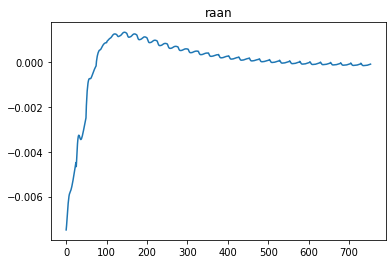

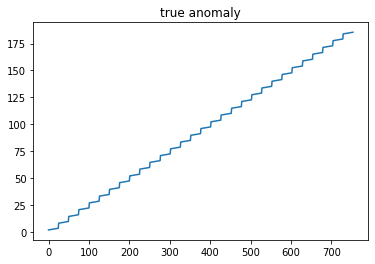

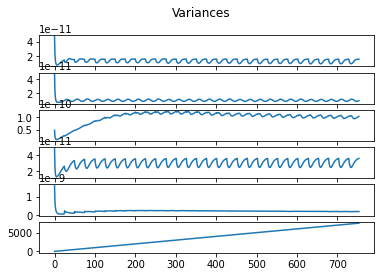

In [14]:
# Plot
import matplotlib.pyplot as plt
plt.plot(EKF_a)
plt.title('a')
plt.show()
plt.plot(EKF_e)
plt.title('e')
plt.show()
plt.plot(EKF_i)
plt.title('i')
plt.show()
plt.plot(EKF_omega)
plt.title('omega')
plt.show()
plt.plot(EKF_raan)
plt.title('raan')
plt.show()
plt.plot(EKF_lv)
plt.title('true anomaly')
plt.show()

fig, axs = plt.subplots(6)
fig.suptitle('Variances')
axs[0].plot(Elt1[:])
axs[1].plot(Elt2[:])
axs[2].plot(Elt3[:])
axs[3].plot(Elt4[:])
axs[4].plot(Elt5[:])
axs[5].plot(Elt6[:])

In [15]:
# Unused

# R14
def performEKF(mesurementsFrame, initialOrbit, initialCOV):
    # Init lists to get the evolution of the filter
    listPropagators = np.array([])
    listOrbits = np.array([])
    listStates = np.array([])
    listCOVmatrixes = np.array([])

    # Init process noise matrix
    Q = MatrixUtils.createRealDiagonalMatrix([1e-0, 1e-0, 1e-0, 1e-0, 1e-0, 1e-0])

    # Init Keplerian Propagator Builder
    integratorBuilder = DormandPrince853IntegratorBuilder(PROP_MIN_STEP, PROP_MAX_STEP, PROP_POS_TOLERANCE)
    kepPropagatorBuilder = NumericalPropagatorBuilder(CartesianOrbit(orbitEstimate), integratorBuilder, PositionAngle.MEAN, estimator_position_scale)

    # Build the Kalman filter
    kalman = KalmanEstimatorBuilder().addPropagationConfiguration(kepPropagatorBuilder,
             ConstantProcessNoise(initialCOV, Q)).estimatedMeasurementsParameters(ParameterDriversList()).build()

    # Process filtering
    for date, meas in mesurements.iterrows():
        kalman.estimationStep(meas['rangeMes'])
        kalman.estimationStep(meas['rangeRateMes'])
        newPropagator = kalman.estimationStep(meas['angularAzElMes'])[0]

    newEstimatedOrbit = newPropagator.getInitialState().getOrbit()
    newEstimatedState = kalman.getPhysicalEstimatedState()
    newCovMatrix = kalman.getPhysicalEstimatedCovarianceMatrix()

    listPropagators = np.append(listPropagators, newPropagator)
    listOrbits = np.append(listOrbits, newEstimatedOrbit)
    listStates = np.append(listStates, newEstimatedState)
    listCovmatrixes = np.append(listCovmatrixes, kalman.getPhysicalEstimatedCovarianceMatrix())

    return listPropagators, listOrbits, listStates, listCovmatrixes